<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script is used to realize unsupervised machine learning (self-organizing maps) of temperature of ERA5.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
from minisom import MiniSom
import matplotlib.pyplot as plt
import time
import numpy as np
from pylab import pcolor,colorbar,bone
from hyperopt import fmin, tpe, hp

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from matplotlib.pyplot import cm
import matplotlib as mpl
from numpy.linalg import norm
import sys
import numpy.ma as ma

### READ DATA

In [2]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

dataset = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [3]:
pres = dataset.variables['pres'][:]
era5_temp = dataset.variables['temp_era5'][:]
mosaic_temp = dataset.variables['temp_mosaic'][:]

### REPLACE MASKED/NAN VALUES BY INTERPOLATION BETWEEN NEAREST VALUES

In [4]:
def replacenan(var) :
    new_var = np.zeros((1399,29))
    for i in range(0,len(var)) :
        for j in range(0,len(var[i])) :
            if ma.getmask(var)[i][j] == True :
                #print('masked value in {}, {}'.format(i,j))
                if j == 28 :
                    #print('value in j-1 : {}, value in j-2 : {}'.format(var[i][j-1],var[i][j-2]))
                    new_var[i][j] = var[i][j-1]+(var[i][j-1]-var[i][j-2])
                    #print('new value :', new_var[i][j])
                else :
                    #print(var[i][j-1],var[i][j+1])
                    new_var[i][j] = np.mean([var[i][j-1],var[i][j+1]])
                    #print(new_var[i][j])
            else :
                new_var[i][j] = var[i][j]  
    return new_var

In [5]:
new_mosaic_temp = replacenan(mosaic_temp)
print('nan values :', ma.count_masked(new_mosaic_temp)) # verify there is no masked/nan values
temp_bias = era5_temp-new_mosaic_temp # bias of temperature between ERA5 and MOSAiC
data = temp_bias

nan values : 0


### SELF-ORGANIZING MAPS

#### Set hyperparameters

In [20]:
x = 4
y = 4
input_len = len(data[1])
iterations = 10000
sigma = 0.2
learning_rate = 0.1

#### Train and plot SOM

In [21]:
def train_som(x, y, input_len, sigma, learning_rate):
    
    # initialization of x*y SOM
    som = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sigma, 
                  learning_rate=learning_rate)
    som.random_weights_init(data)
    
    # training
    start_time = time.time()
    som.train_random(data,iterations)
    elapsed_time = time.time() - start_time
    #print(elapsed_time, "seconds")
    print('total_q_error :', som.quantization_error(data))
    
    return som

In [22]:
som = train_som(x, y, input_len, sigma, learning_rate)

total_q_error : 3.5083111972559085


In [16]:
for i in range(1, 10, 1) :
    for j in range(1, 10, 1):
        som = train_som(x, y, input_len, i/10, j/10)
        print('s = {}, lt = {}, q = {}'.format(i/10, j/10, np.round(som.quantization_error(data),3)))

s = 0.1, lt = 0.1, q = 3.496
s = 0.1, lt = 0.2, q = 3.495
s = 0.1, lt = 0.3, q = 3.541
s = 0.1, lt = 0.4, q = 3.661
s = 0.1, lt = 0.5, q = 3.738
s = 0.1, lt = 0.6, q = 3.763
s = 0.1, lt = 0.7, q = 3.977
s = 0.1, lt = 0.8, q = 3.817
s = 0.1, lt = 0.9, q = 4.126
s = 0.2, lt = 0.1, q = 3.481
s = 0.2, lt = 0.2, q = 3.557
s = 0.2, lt = 0.3, q = 3.685
s = 0.2, lt = 0.4, q = 3.692
s = 0.2, lt = 0.5, q = 3.722
s = 0.2, lt = 0.6, q = 3.884
s = 0.2, lt = 0.7, q = 3.782
s = 0.2, lt = 0.8, q = 3.856
s = 0.2, lt = 0.9, q = 4.035
s = 0.3, lt = 0.1, q = 3.53
s = 0.3, lt = 0.2, q = 3.541
s = 0.3, lt = 0.3, q = 3.592
s = 0.3, lt = 0.4, q = 3.664
s = 0.3, lt = 0.5, q = 3.709
s = 0.3, lt = 0.6, q = 3.803
s = 0.3, lt = 0.7, q = 3.782
s = 0.3, lt = 0.8, q = 3.845
s = 0.3, lt = 0.9, q = 3.959
s = 0.4, lt = 0.1, q = 3.485
s = 0.4, lt = 0.2, q = 3.492
s = 0.4, lt = 0.3, q = 3.501
s = 0.4, lt = 0.4, q = 3.684
s = 0.4, lt = 0.5, q = 3.735
s = 0.4, lt = 0.6, q = 3.855
s = 0.4, lt = 0.7, q = 4.005
s = 0.4, lt = 0

In [23]:
def plot_som(som):
    plt.figure(figsize=(6, 6))
    plt.imshow(som.distance_map()) #normalised sum of the distances between a neuron and its neighbours (euclidean distance)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 4, 1))
    ax.set_yticks(np.arange(-.5, 4, 1))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_yticklabels(np.arange(0, 5, 1))

In [24]:
som.distance_map()

array([[0.14037347, 0.29524223, 0.26862561, 0.16012782],
       [0.37012564, 0.47355805, 0.47353179, 0.53783639],
       [0.79656254, 0.81190229, 0.48020515, 0.49901091],
       [1.        , 0.63383282, 0.23649448, 0.21157853]])

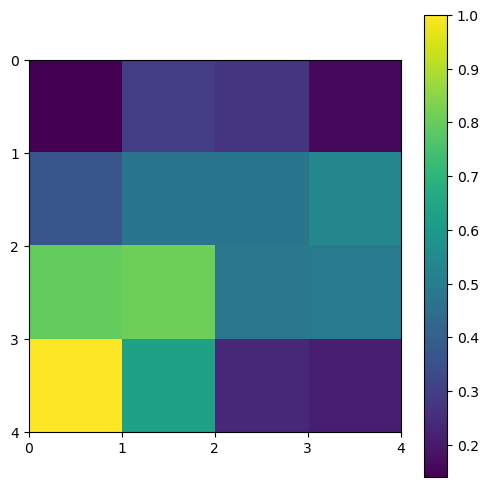

In [25]:
plot_som(som)

#### Tuning sigma by reducing quantization error with hyperopt.fmin

In [46]:
start_time = time.time()
best = fmin(
    fn=lambda sig: MiniSom(x=x, 
              y=y, 
              input_len=input_len, 
              sigma=sig, 
              learning_rate=learning_rate).quantization_error(data),
    space=hp.uniform("sig", 0.001, x / 2.01),
    algo=tpe.suggest,
    max_evals=200)
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds")
print(best)

100%|███████| 200/200 [00:00<00:00, 329.06trial/s, best loss: 5.000277451861222]
0.6427617073059082 seconds
{'sig': 1.0761846752161883}


In [47]:
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 1.0761846752161883
learning_rate: 0.05


#### Train and plot SOM with new sigma setting

1.2630085945129395 seconds
total_q_error : 3.7201620386488043


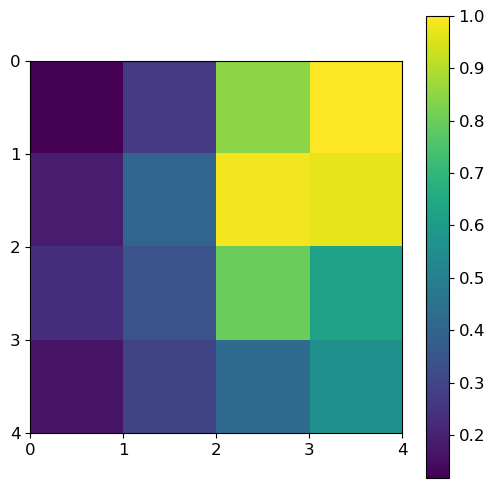

In [48]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

#### Optimizing sigma and learning rate

In [73]:
from hyperopt import Trials, STATUS_OK

space={
        'sig': hp.uniform('sig', 0.001, 5),
        'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }
def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sig, 
                  learning_rate=learning_rate).quantization_error(data)
    #print(val)
    return {'loss': val, 'status': STATUS_OK}

trials =  Trials()
best = fmin(fn=som_fn,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print('best: {}'.format(best))
for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

100%|███████| 100/100 [00:00<00:00, 281.08trial/s, best loss: 5.002010809237756]
best: {'learning_rate': 1.3170923661875538, 'sig': 3.793993719075493}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 5.029217554397979, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [4.148741311852251], 'sig': [4.319073391591527]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2023, 4, 20, 14, 21, 26, 955000), 'refresh_time': datetime.datetime(2023, 4, 20, 14, 21, 26, 956000)}
1 {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 5.049066586387548, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'sig': [1]}, 'vals': {'learning_rate': [2.86349968137637], 'sig': [3.759414913458906]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.dat

In [74]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 3.793993719075493
learning_rate: 1.3170923661875538


#### Train and plot SOM with new sigma and learning rate settings

1.267782211303711 seconds
total_q_error : 4.884815520742464


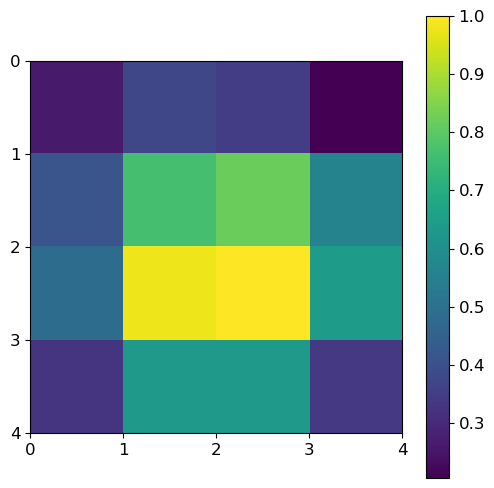

In [75]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

#### QUANTIZATION TOPOGRAPHIC ERRORS OVER ITERATIONS

iteration=99999 status=100.00% error=3.462502788522818

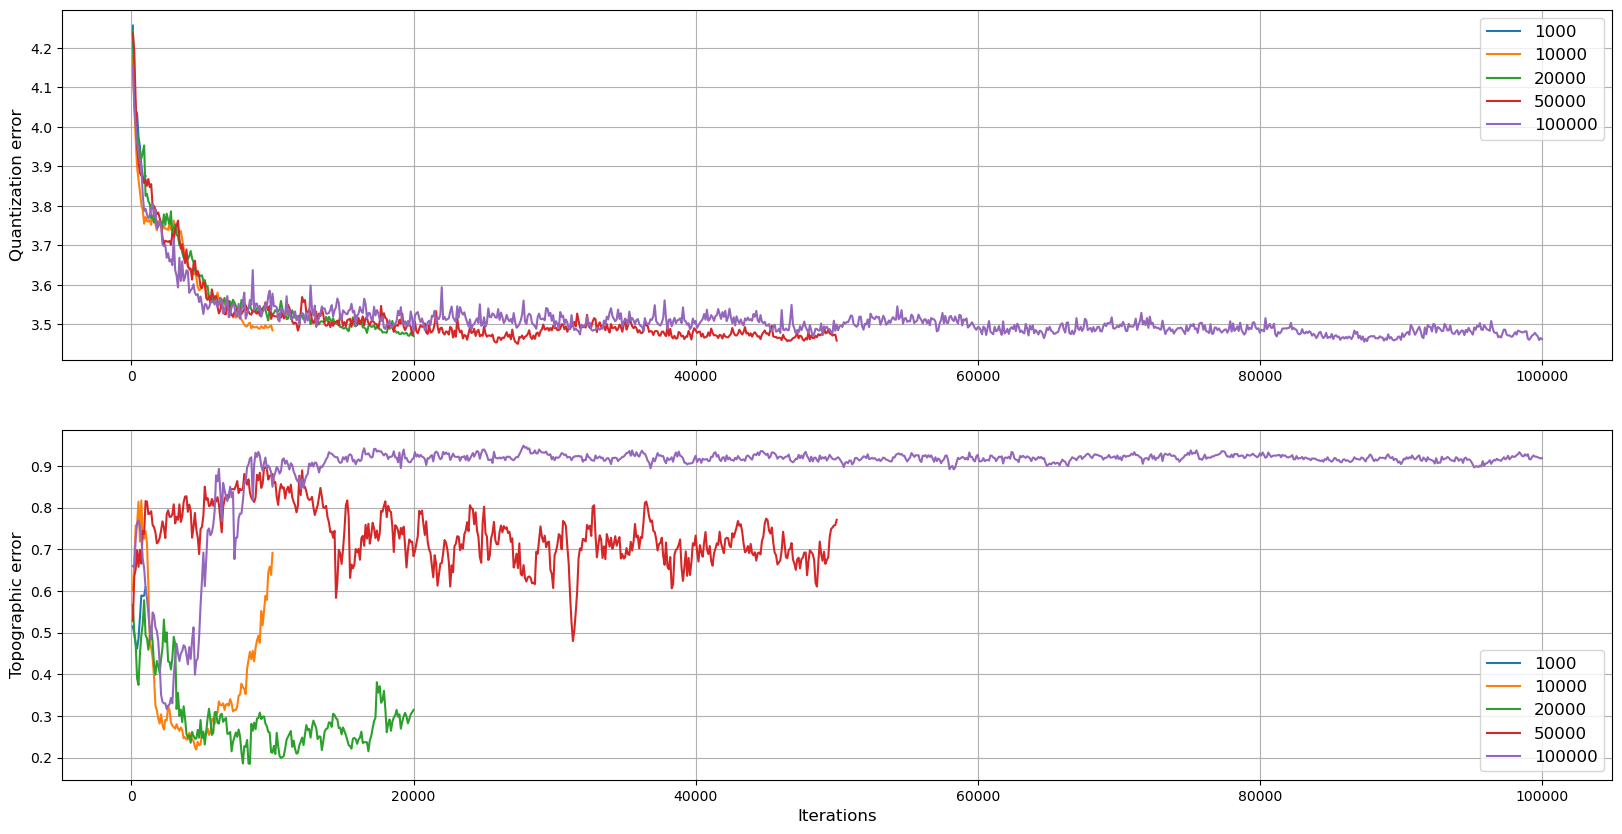

In [26]:
parameters = {'axes.labelsize':12, 'axes.titlesize':10, 'legend.fontsize':12, 'xtick.labelsize':10, 'ytick.labelsize':10, 
                  'legend.title_fontsize':10, 'figure.titlesize':25}
plt.rcParams.update(parameters)

max_iter = [1000,10000,20000,50000,100000]

fig, axs = plt.subplots(2,1,figsize=(20,10))
for num_iter in max_iter:
    som = MiniSom(x, y, input_len=input_len, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function='gaussian', random_seed=10)
    som.random_weights_init(data)
    
    q_error_list = [] ; t_error_list = [] ; iter_x = []
    for i in range(num_iter):
        percent = 100*(i+1)/num_iter
        rand_i = np.random.randint(len(data))
        som.update(data[rand_i], som.winner(data[rand_i]), i, num_iter)
        if (i+1) % 100 == 0:
            q_error = som.quantization_error(data)
            t_error = som.topographic_error(data)
            q_error_list.append(q_error)
            t_error_list.append(t_error)
            iter_x.append(i)
            sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}% error={q_error}')
    axs[0].plot(iter_x,q_error_list, label='{}'.format(num_iter))
    axs[1].plot(iter_x,t_error_list, label='{}'.format(num_iter))
axs[0].set_ylabel('Quantization error')
axs[1].set_ylabel('Topographic error')
axs[1].set_xlabel('Iterations')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_qerror.png',dpi=300)
#it converges faster with fewer iterations because the learning rate decreases when the number of iterations increases

#### Parameters from minisom library, usefull for plot

In [27]:
neuron_weights = som.get_weights()           # neuron weights for each neuron
win_map = som.win_map(data)                  # profiles sort by indices of neuron
nb_profiles = som.activation_response(data)  # number of profiles in each neuron
print('number of profiles : \n', nb_profiles)

number of profiles : 
 [[  5.   8. 672.  19.]
 [  5.  16.  20.  23.]
 [ 39.  60.   7. 177.]
 [113. 219.   5.  11.]]


#### Nodes activated more often (number of profiles in each neuron)

[Text(0, -0.5, '0'),
 Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4')]

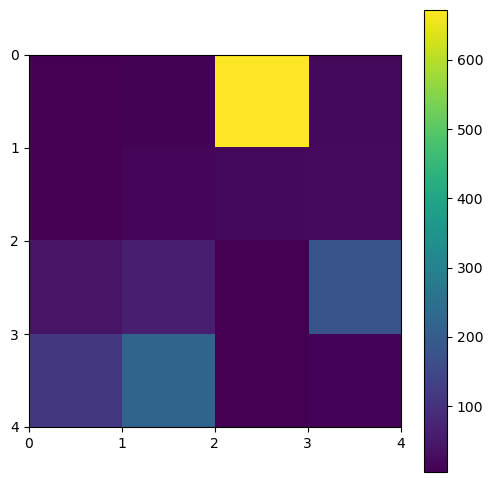

In [28]:
plt.figure(figsize=(6, 6))
nb_profiles = som.activation_response(data)
plt.imshow(nb_profiles)
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 4, 1))
ax.set_yticks(np.arange(-.5, 4, 1))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))

In [29]:
np.shape(som._distance_from_weights(data))
som._distance_from_weights(data)[0,:]

array([37.63543938, 13.45131453,  2.71914961, 20.96799923, 76.03548146,
       11.37963468, 18.26590607, 10.02032787, 10.3367636 ,  5.18542527,
        7.79957261,  3.74015281,  5.15559579,  3.32939249, 28.7079473 ,
       19.61834984])

#### MEAN SQUARED ERROR, ROOT MEAN SQUARED ERROR, QUANTIZATION ERROR IN EACH NEURON AND IN TOTAL

In [30]:
# Create dictionaries with neuron_name being the corresponding neuron 
mae_neuron_list = {} ; rmse_neuron_list = {} ; q_error_neuron_list = {} ; q_error_2_neuron_list = {}
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron_list[neuron_name] = []
        rmse_neuron_list[neuron_name] = []
        q_error_neuron_list[neuron_name] = []
        q_error_2_neuron_list[neuron_name] = []

In [31]:
winner_list=[] ; mae_list=[] ; rmse_list=[] ; q_error_list = [] ; q_error_2_list=[]
bmu = som.quantization(data) #BMU for each temperature profile (neuron_weight corresponding to each temperature profile)

for ix in range(len(data)):
    winner = som.winner(data[ix]) #(i,j) indexes of the winner neuron for each profile
    winner_list.append(winner)
    
    # For one profile :
    mae = mean_absolute_error(data[ix],bmu[ix]) #abs(np.subtract(data[ix],bmu[ix])).mean()
    mse = mean_squared_error(data[ix],bmu[ix]) #np.square(np.subtract(data[ix],bmu[ix])).mean()
    rmse = np.sqrt(mse)
    q_error = norm(data[ix]-bmu[ix]) #error along the profile
    q_error_2 = np.sqrt(norm(data[ix]-bmu[ix])**2/len(data[ix])) #error per pressure level
    
    # List of values for all profiles :
    mae_list.append(mae)
    rmse_list.append(rmse)
    q_error_list.append(q_error)
    q_error_2_list.append(q_error_2)
    
    # Putting values in corresponding neuron of the dictionary :
    neuron_name = 'neuron_'+str(winner[0])+'_'+str(winner[1])
    mae_neuron_list[neuron_name].append(mae)
    rmse_neuron_list[neuron_name].append(rmse)
    q_error_neuron_list[neuron_name].append(q_error)
    q_error_2_neuron_list[neuron_name].append(q_error_2)

In [32]:
# Mean in each neuron
mae_neuron=[] ; rmse_neuron=[] ; q_error_neuron=[] ; q_error_2_neuron=[]
for i in range(0,x) :
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron.append(np.mean(mae_neuron_list[neuron_name]))
        rmse_neuron.append(np.mean(rmse_neuron_list[neuron_name]))
        q_error_neuron.append(np.mean(q_error_neuron_list[neuron_name]))
        q_error_2_neuron.append(np.mean(q_error_2_neuron_list[neuron_name]))

In [33]:
# On all profiles (my calcul)
total_mae = np.mean(mae_list)
total_rmse = np.mean(rmse_list)
total_q_error = np.mean(q_error_list)
total_q_error_2 = np.mean(q_error_2_list)

In [34]:
# On all profiles (from python functions)
mae_total = mean_absolute_error(data,bmu) #per profile, per pressure level
mse_total = mean_squared_error(data,bmu) #per profile, per pressure level
rmse_total = np.sqrt(mse_total) #per profile, per pressure level
q_error_total = som.quantization_error(data) #per profile on all pressure levels

In [35]:
print('My calcul : \n mae : {} K (per level pressure and per profile) \nrmse : {} K (per level pressure and per profile) \nq_error :  {} K (per profile) \n'.format(total_mae, total_rmse, total_q_error))
print('Calcul from python functions : \n mae : {} K\nrmse : {} K \nq_error :  {} K \n'.format(mae_total, rmse_total, q_error_total))
print('q_error per profile and per pressure level : {} K'.format(total_q_error_2))

My calcul : 
 mae : 0.47021966107081475 K (per level pressure and per profile) 
rmse : 0.6429706262537297 K (per level pressure and per profile) 
q_error :  3.462502788522818 K (per profile) 

Calcul from python functions : 
 mae : 0.4702196610708146 K
rmse : 0.7713867106638964 K 
q_error :  3.462502788522818 K 

q_error per profile and per pressure level : 0.6429706262537297 K


### PLOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


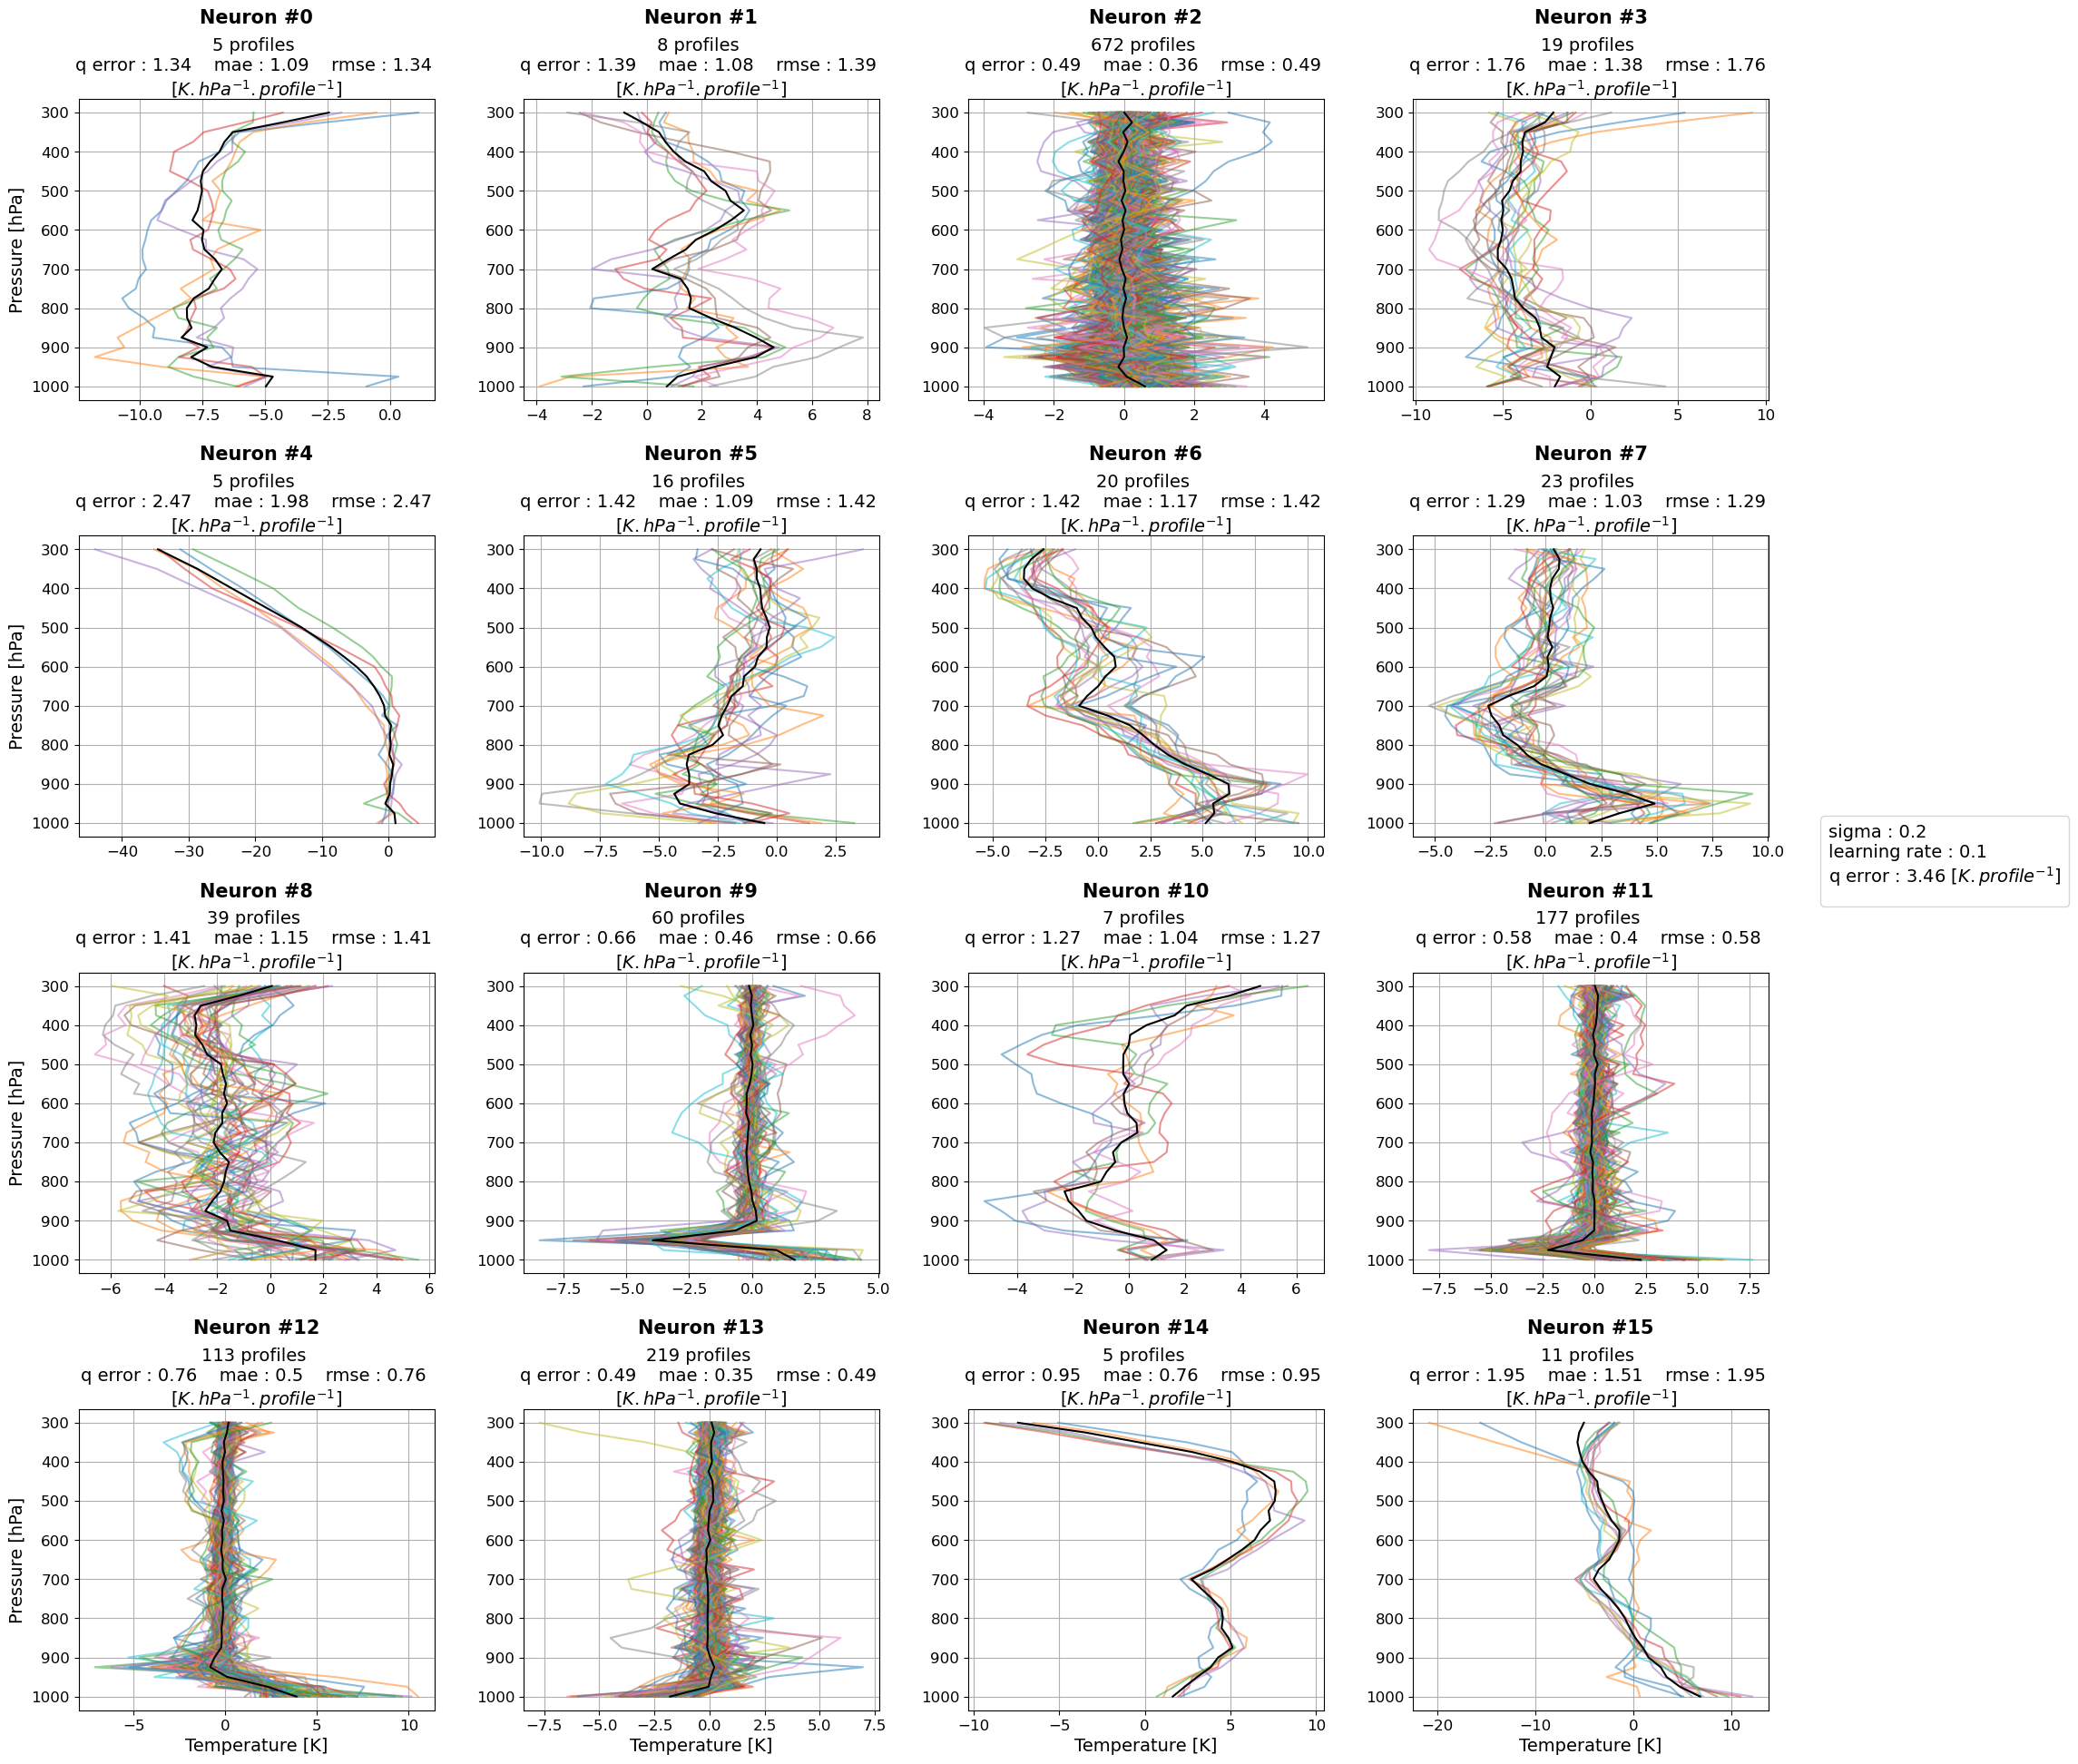

In [36]:
parameters = {'axes.labelsize':14, 'axes.titlesize':15, 'legend.fontsize':16, 'xtick.labelsize':12, 'ytick.labelsize':12, 
                  'legend.title_fontsize':14, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig, axs = plt.subplots(x,y,figsize=(20,20))
t=0
for i in range(0,x) :
     for n in range(0,y) :
        for m in range(len(win_map[(i,n)])) :
            axs[i,n].plot(win_map[(i,n)][m], pres, alpha=0.5)
        axs[i,n].plot(neuron_weights[i][n], pres, 'k')
        axs[i,n].invert_yaxis()
        axs[i,n].grid()
        axs[i,n].set_title('Neuron #'+str(t), pad=60, weight='bold')
        axs[i,n].text(0.5,1.1, '{} profiles \nq error : {}    mae : {}    rmse : {} \n[$K.hPa^{{-1}}.profile^{{-1}}$]'.format(int(nb_profiles[i][n]),
            np.round(q_error_2_neuron[t],2), np.round(mae_neuron[t],2), np.round(rmse_neuron[t], 2)), horizontalalignment='center',
                      verticalalignment='center', transform = axs[i,n].transAxes, fontsize=14)
        if n==0 :
            axs[i,n].set_ylabel('Pressure [hPa]')
        if i>2 :
            axs[i,n].set_xlabel('Temperature [K]')
       
        t = t+1
        
fig.tight_layout()        
fig.subplots_adjust(top=0.92, hspace=0.45)
lgd = fig.legend(loc='center left',  bbox_to_anchor=(1, 0.5), title='sigma : {} \nlearning rate : {} \nq error : {} [$K.profile^{{-1}}$]'.format(np.round(sigma,2),
                                                                                                        np.round(learning_rate,2),
                                                                                                        np.round(q_error_total,2)))

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_SOM.png',dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')